### Dynamic Cluster-Based Portfolio Optimization in S&P 500 Stocks

This quantitative finance project employs an unsupervised machine learning approach, specifically K-Means clustering, to develop a dynamic trading strategy for S&P 500 stocks. It begins by fetching and preparing historical stock data, calculating various technical indicators and liquidity measures, and then integrating Fama-French factors to understand market risks. Stocks are clustered based on their features, and portfolios are formed monthly from the most liquid cluster, optimized for maximum Sharpe ratio using the Efficient Frontier method. The strategy's performance is dynamically calculated and compared against the S&P 500 benchmark to assess its effectiveness. The project encapsulates data-driven asset selection, risk management, and performance evaluation, aiming to create a robust algorithmic trading strategy that adapts to market conditions and outperforms standard benchmarks.

In [3]:
from statsmodels.regression.rolling import RollingOLS
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pandas_ta
import warnings
import datetime as dt
import yfinance as yf
yf.pdr_override()
warnings.filterwarnings('ignore')



### S&P 500 Stock Data Retrieval and Preprocessing

This portion is dedicated to retrieving and preprocessing historical stock data for companies listed in the S&P 500 index. Initially, it fetches the list of S&P 500 companies from Wikipedia and formats their symbols for compatibility. It then defines a time range of 8 years ending on November 24, 2023, for historical data retrieval. Utilizing the `pandas_datareader` library, it fetches the stock data for each symbol over the specified period. The data is then restructured with multi-level indexing by date and ticker symbol, and all column names are converted to lowercase for uniformity. Finally, it displays the first few rows of the prepared dataset. This process sets a foundation for further analysis, feature extraction, and machine learning modeling in algorithmic trading strategies.

In [5]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-11-24'

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = pdr.get_data_yahoo(symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.head()

[*********************100%%**********************]  503 of 503 completed


adj close      close       high        low       open  \
date       ticker                                                          
2015-11-27 A       39.293129  41.970001  42.200001  41.160000  41.320000   
           AAL     39.840870  41.689999  42.250000  41.169998  41.380001   
           AAPL    26.813349  29.452499  29.602501  29.400000  29.572500   
           ABBV    42.469799  60.000000  60.450001  59.610001  60.169998   
           ABT     39.099823  45.419998  45.599998  45.310001  45.419998   

                       volume  
date       ticker              
2015-11-27 A        1935700.0  
           AAL      3066600.0  
           AAPL    52185600.0  
           ABBV     2404100.0  
           ABT      1678000.0

### Feature Calculation for Trading Indicators

In this section, various technical indicators are calculated and appended as features to the dataset. These features are designed to provide insights into the price movements and volatility of the S&P 500 stocks:

- **Garman-Klass Volatility (`garman_klass_vol`):** A measure of volatility that accounts for both opening and closing prices. It's a more refined measure than simple historical volatility and is used to estimate the volatility of stock prices over the time period.
- **Relative Strength Index (`rsi`):** A momentum oscillator that measures the speed and change of price movements. It oscillates between zero and 100 and is typically used to identify overbought or oversold conditions in a traded asset.
- **Bollinger Bands (`bb_low`, `bb_mid`, `bb_high`):** A set of trend indicators derived from a moving average and standard deviation of prices. It includes a middle band (20-day simple moving average) and an upper and lower band that are standard deviations away from the middle band.
- **Average True Range (`atr`):** A market volatility indicator that measures the degree of price volatility by decomposing the entire range of an asset price for that period.
- **Moving Average Convergence Divergence (`macd`):** A trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It's used to spot changes in the strength, direction, momentum, and duration of a trend in a stock's price.
- **Dollar Volume (`dollar_volume`):** A liquidity metric that represents the total value of shares traded over a period. It's calculated by multiplying the adjusted close price by the volume of shares traded, typically used to weigh the significance of trading data.

Each of these features is calculated per ticker and added as a new column to the dataframe, providing a rich set of variables for further analysis and modeling in the context of algorithmic trading strategies.

In [6]:
# Calculate Features

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))   # group by ticker

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close= stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level = 1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df


adj close       close        high         low        open  \
date       ticker                                                               
2015-11-27 A        39.293129   41.970001   42.200001   41.160000   41.320000   
           AAL      39.840870   41.689999   42.250000   41.169998   41.380001   
           AAPL     26.813349   29.452499   29.602501   29.400000   29.572500   
           ABBV     42.469799   60.000000   60.450001   59.610001   60.169998   
           ABT      39.099823   45.419998   45.599998   45.310001   45.419998   
...                       ...         ...         ...         ...         ...   
2023-11-22 YUM     128.332977  128.940002  129.350006  128.529999  128.919998   
           ZBH     113.830002  113.830002  114.800003  113.199997  113.820000   
           ZBRA    225.860001  225.860001  227.000000  221.589996  223.399994   
           ZION     34.410000   34.410000   35.000000   34.169998   34.689999   
           ZTS     179.350006  179.350006  180.970001  178.779999  180.000000   

                       volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-11-27 A        1935700.0         -0.000666        NaN       NaN   
           AAL      3066600.0         -0.000220        NaN       NaN   
           AAPL    52185600.0         -0.003682        NaN       NaN   
           ABBV     2404100.0         -0.046786        NaN       NaN   
           ABT      1678000.0         -0.008652        NaN       NaN   
...                       ...               ...        ...       ...   
2023-11-22 YUM       980600.0          0.000012  61.152837  4.781184   
           ZBH      1246200.0          0.000098  58.455036  4.624017   
           ZBRA      550100.0          0.000245  54.738384  5.287608   
           ZION     1441300.0          0.000263  52.781967  3.402097   
           ZTS      1501500.0          0.000069  60.171137  5.024061   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-11-27 A            NaN       NaN       NaN       NaN      76.059710  
           AAL          NaN       NaN       NaN       NaN     122.176012  
           AAPL         NaN       NaN       NaN       NaN    1399.270694  
           ABBV         NaN       NaN       NaN       NaN     102.101644  
           ABT          NaN       NaN       NaN       NaN      65.609503  
...                     ...       ...       ...       ...            ...  
2023-11-22 YUM     4.830983  4.880782  0.060650  0.995591     125.843318  
           ZBH     4.688358  4.752700 -0.397419  0.440918     141.854948  
           ZBRA    5.355359  5.423110 -0.067039  0.068501     124.245586  
           ZION    3.530520  3.658942 -0.108972  0.583889      49.595133  
           ZTS     5.123997  5.223933  0.872859  0.896584     269.294034  

[993525 rows x 14 columns]

### Monthly Aggregation and Liquidity Filtering

In this section, the dataset is transformed to a monthly frequency to focus on the most liquid stocks. It first calculates the mean dollar volume per month for each stock to assess liquidity. Then, it resamples other relevant features (excluding volume and price-related columns) to their last available data point each month, ensuring a consistent monthly snapshot. These steps are combined to form a comprehensive monthly dataset. While the code snippet provided doesn't explicitly filter stocks, typically, the next step would involve selecting the top 150 most liquid stocks each month based on the calculated dollar volume, ensuring the focus is on highly traded and therefore more predictable stocks for algorithmic trading.

In [7]:
# Aggregate to monthly level and filter top 150 most liquid stocks for each month
# Convert business-daily data to month-end frequency
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                   axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-01-31 A           95.369735   35.345039 -0.883561  3.682282  3.532355   
           AAL        475.458011   37.260624  2.040709  3.723517  3.618183   
           AAPL      5981.206593   22.154413 -0.832277  3.215938  3.095448   
           ABBV       460.247982   39.268002  0.190464  3.788067  3.650394   
           ABT        326.006448   32.788799 -0.470880  3.667053  3.508551   
...                          ...         ...       ...       ...       ...   
2023-11-30 YUM        174.181126  128.332977  0.060650  4.880782  4.781184   
           ZBH        230.142825  113.830002 -0.397419  4.752700  4.624017   
           ZBRA       105.747846  225.860001 -0.067039  5.423110  5.287608   
           ZION        70.672168   34.410000 -0.108972  3.658942  3.402097   
           ZTS        416.120116  179.350006  0.872859  5.223933  5.024061   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-01-31 A       3.607319          0.000336 -0.642485  42.111291  
           AAL     3.670850          0.002147 -0.976990  42.980111  
           AAPL    3.155693         -0.001265 -0.678794  40.392910  
           ABBV    3.719231         -0.035988 -0.170572  45.155378  
           ABT     3.587802         -0.004372 -1.217502  34.093600  
...                     ...               ...       ...        ...  
2023-11-30 YUM     4.830983          0.000012  0.995591  61.152837  
           ZBH     4.688358          0.000098  0.440918  58.455036  
           ZBRA    5.355359          0.000245  0.068501  54.738384  
           ZION    3.530520          0.000263  0.583889  52.781967  
           ZTS     5.123997          0.000069  0.896584  60.171137  

[46933 rows x 9 columns]

### Liquidity Ranking and Selection

This section calculates a 5-year rolling average of dollar volume for each stock to provide a stable measure of liquidity over time. It then ranks stocks monthly based on this average, selecting only the top 150 most liquid stocks for inclusion. This method ensures a focus on consistently liquid stocks, reducing the impact of short-term volume spikes and enhancing the robustness of trading strategies. After ranking, the original dollar volume and rank columns are removed, leaving a streamlined dataset of liquid stocks with their respective features, ready for further analysis or trading algorithm development.

In [8]:
# Calculate 5-year rolling average of dollar volume for each stocks before filtering

data ['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-12-31 AAL      45.118095  0.388998  3.899765  3.813338  3.856552   
           AAPL     26.946924 -1.115686  3.364473  3.274855  3.319664   
           ABBV     46.037792 -1.258414  3.863187  3.809937  3.836562   
           ABT      33.897533 -1.179309  3.575095  3.535751  3.555423   
           ACN     105.149292 -0.905129  4.743385  4.641425  4.692405   
...                       ...       ...       ...       ...       ...   
2023-11-30 VRTX    353.230011  1.535382  5.966103  5.837572  5.901838   
           VZ       37.349998 -0.888533  3.651786  3.556195  3.603990   
           WFC      42.779999 -0.894656  3.806127  3.671914  3.739020   
           WMT     154.097672  0.881379  5.149324  5.037185  5.093254   
           XOM     104.010002  0.618574  4.686199  4.629006  4.657602   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-12-31 AAL            -0.000637  1.018425  52.919058  
           AAPL           -0.002296 -0.109648  57.499024  
           ABBV           -0.036939 -0.013996  54.830574  
           ABT            -0.005705 -0.349321  45.324665  
           ACN            -0.004741 -0.349012  44.676185  
...                             ...       ...        ...  
2023-11-30 VRTX            0.000241 -0.924427  45.789751  
           VZ              0.000032  2.095390  70.183223  
           WFC             0.000048  0.821585  59.354618  
           WMT             0.000016 -1.258115  38.335167  
           XOM             0.000150 -1.186418  44.368583  

[12516 rows x 8 columns]

### Momentum Feature Calculation

In this section, the code calculates monthly returns for various time horizons to capture momentum patterns in stock prices, a key concept in financial markets indicating the continuation of asset price trends. The process is as follows:

- **Return Calculation:** Monthly returns are calculated over different time horizons (1, 2, 3, 6, 9, and 12 months) using the percentage change method. These varying lags help capture short-term to long-term momentum.
- **Outlier Handling:** To mitigate the impact of extreme movements, returns are clipped at the 0.5th and 99.5th percentiles, ensuring the model focuses on more typical market movements and reduces the influence of outliers.
- **Normalization:** The returns are then normalized over the respective time period to make them comparable across different horizons.
- **Grouping and Cleaning:** The calculations are performed for each stock individually, ensuring that the momentum features are specific to each stock's price history. Finally, any rows with missing data are dropped to maintain a clean dataset.

By the end of this process, the `data` dataframe includes a set of momentum-based features for each stock, reflecting different aspects of their historical price movements. These features are valuable for identifying and exploiting trends in stock prices, forming a critical part of the feature set for any momentum-based trading strategy.

In [9]:
# Calculate monthly returns for different time horizons as features
# Capture time series dynamics that reflect momentum patterns. Use .pct_change(lag), which is the returns over various monthly periods as identified by lags

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f"return_{lag}m"] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper = x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711876 -0.113375  3.972856  3.884601  3.928729   
           AAPL     40.006569 -0.983887  3.754309  3.703448  3.728878   
           ABBV     73.694946 -0.694228  4.338743  4.289143  4.313943   
           ABT      51.533810 -1.123040  3.978439  3.904342  3.941390   
           ACN     140.201767 -0.908208  4.967737  4.907500  4.937618   
...                       ...       ...       ...       ...       ...   
2023-11-30 VRTX    353.230011  1.535382  5.966103  5.837572  5.901838   
           VZ       37.349998 -0.888533  3.651786  3.556195  3.603990   
           WFC      42.779999 -0.894656  3.806127  3.671914  3.739020   
           WMT     154.097672  0.881379  5.149324  5.037185  5.093254   
           XOM     104.010002  0.618574  4.686199  4.629006  4.657602   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-12-31 AAL            -0.000305  1.250945  59.214230   0.030501   
           AAPL           -0.001526 -0.220654  47.784549  -0.015246   
           ABBV           -0.031544  0.192946  55.000825  -0.002167   
           ABT            -0.004710  0.255865  59.877807   0.012418   
           ACN            -0.003561  0.296514  65.003391   0.034322   
...                             ...       ...        ...        ...   
2023-11-30 VRTX            0.000241 -0.924427  45.789751  -0.024523   
           VZ              0.000032  2.095390  70.183223   0.063194   
           WFC             0.000048  0.821585  59.354618   0.085275   
           WMT             0.000016 -1.258115  38.335167  -0.053485   
           XOM             0.000150 -1.186418  44.368583  -0.008398   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-12-31 AAL      0.055325   0.031653   0.006292   0.023994    0.009787  
           AAPL     0.002359   0.032902   0.028535   0.019684    0.033479  
           ABBV     0.035171   0.031006   0.051953   0.047851    0.039985  
           ABT      0.025851   0.024323   0.028884   0.030147    0.035524  
           ACN      0.037001   0.045983   0.037860   0.029824    0.024265  
...                      ...        ...        ...        ...         ...  
2023-11-30 VRTX     0.007863   0.004658   0.014725   0.022044    0.009218  
           VZ       0.078338   0.029314   0.014438   0.001883    0.002349  
           WFC      0.027776   0.014885   0.014879  -0.007165   -0.006915  
           WMT     -0.016582  -0.016548   0.009258   0.010722    0.002490  
           XOM     -0.055184  -0.019033   0.005853  -0.003247   -0.002873  

[10347 rows x 14 columns]

### Rolling Factor Beta Calculation with Fama-French Factors

This section involves integrating Fama-French factors, renowned in finance for explaining stock returns, and calculating rolling factor betas for each stock. The code fetches the Fama-French 5-factor model data, excludes the risk-free rate, and resamples it to monthly frequency to align with the stock data. It then merges this with the 1-month stock returns, setting the stage for subsequent rolling beta calculations. These calculations will typically involve a rolling regression of stock returns against the factor returns, providing insights into each stock's sensitivity to different market risks. The final dataset, `factor_data`, is a comprehensive monthly series of factor exposures and stock returns, ready for advanced risk modeling and investment strategy development.

In [10]:
# Download Fama-French Factors and Calculate Rolling Factor Betas

reader = pdr.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', '2010')
factor_data = reader.read()
factor_data = factor_data[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10201 rows x 6 columns]

### Ensuring Data Sufficiency for Stocks

This code filters the factor data to include only stocks with at least 10 months of historical data, ensuring sufficient data points for reliable analysis. It first counts the monthly observations for each stock, identifies those meeting the data threshold, and then retains only these stocks in the `factor_data` dataframe. This step is crucial for maintaining the integrity and reliability of subsequent financial analyses or modeling efforts.

In [11]:
# Filter out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10155 rows x 6 columns]

### Calculating Rolling Factor Betas for Stocks

This section of the code calculates rolling factor betas for each stock, providing a dynamic measure of each stock's sensitivity to the Fama-French factors over time. It uses a rolling window Ordinary Least Squares (OLS) regression with a minimum of 24 months (or the available data if less) to estimate the betas. The regression is performed for each stock individually, using the stock's 1-month returns as the dependent variable and the Fama-French factors as independent variables. The constant term is excluded after fitting to focus solely on the factor sensitivities. The resulting `betas` dataframe contains the time-varying factor betas for each stock, reflecting how its returns relate to broader market movements and specific risk factors, a critical input for risk management and strategic asset allocation.

In [12]:
# Calculate Rolling Factor Betas

betas = (factor_data.groupby(level=1,
                             group_keys=False)
                             .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                         exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                         window = min(24, x.shape[0]),
                                                         min_nobs=len(x.columns)+ 1)
                                .fit(params_only=True)
                                .params
                                .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-12-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-10-31 VRTX    0.516149 -0.609212 -0.241884 -0.128993  0.711790
           VZ      0.351239 -0.546773  0.454532  0.271668 -0.153891
           WFC     1.081143  0.342197  2.046441 -0.410925 -1.505579
           WMT     0.686486 -0.333352 -0.423076 -0.136836  0.516193
           XOM     1.016496 -0.783471  1.607337 -0.639911 -0.142266

[10155 rows x 5 columns]

### Integrating Rolling Factor Betas into Main Dataset

The code enhances the main dataset by joining the calculated rolling factor betas, enriching each stock's features with its sensitivities to the Fama-French factors. It addresses any missing beta values by filling them with the mean beta per stock, ensuring a complete and consistent dataset. The 'adj close' column and any rows with remaining NA values are dropped to tidy up the data. Finally, it verifies the structure and completeness of the updated dataset with `data.info()`, ensuring it's ready for comprehensive financial analysis or modeling, now equipped with both original stock features and dynamic factor exposures.

In [13]:
# Join Rolling Factors data to main features dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# Drop 'adj close' and any rows with NA values
data = data.drop('adj close', axis=1)
data = data.dropna()

# Check the resulting DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10122 entries, (Timestamp('2017-12-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-11-30 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10122 non-null  float64
 1   bb_high           10122 non-null  float64
 2   bb_low            10122 non-null  float64
 3   bb_mid            10122 non-null  float64
 4   garman_klass_vol  10122 non-null  float64
 5   macd              10122 non-null  float64
 6   rsi               10122 non-null  float64
 7   return_1m         10122 non-null  float64
 8   return_2m         10122 non-null  float64
 9   return_3m         10122 non-null  float64
 10  return_6m         10122 non-null  float64
 11  return_9m         10122 non-null  float64
 12  return_12m        10122 non-null  float64
 13  Mkt-RF            10122 non-null  float64
 14  SMB               10122 non-null  floa

### Implementing K-Means Clustering on Financial Data

This section applies K-Means clustering to the financial dataset, aiming to group stocks based on their features, including the newly integrated factor betas. The clustering process is customized with initial centroids based on target RSI (Relative Strength Index) values, a key technical indicator. Specifically, four clusters are initialized with RSI values of 30, 45, 55, and 70, representing different market conditions. The K-Means algorithm, with these initial centroids, is applied to the dataset, grouping stocks into four clusters based on their similarity across all features. This clustering is performed separately for each date, ensuring that the dynamic nature of financial markets is captured. The resulting `data` dataframe includes a new 'cluster' column, indicating the cluster assignment for each stock on each date, providing a basis for further analysis like segmenting stocks based on their market behavior or identifying patterns within each cluster.

In [24]:
# K Means Clustering
from sklearn.cluster import KMeans
data= data.drop('cluster',axis=1)
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values
initial_centroids
n = 4
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=n,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data 

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-12-31 AAL    -0.113375  3.972856  3.884601  3.928729         -0.000305   
           AAPL   -0.983887  3.754309  3.703448  3.728878         -0.001526   
           ABBV   -0.694228  4.338743  4.289143  4.313943         -0.031544   
           ABT    -1.123040  3.978439  3.904342  3.941390         -0.004710   
           ACN    -0.908208  4.967737  4.907500  4.937618         -0.003561   
...                     ...       ...       ...       ...               ...   
2023-11-30 VRTX    1.535382  5.966103  5.837572  5.901838          0.000241   
           VZ     -0.888533  3.651786  3.556195  3.603990          0.000032   
           WFC    -0.894656  3.806127  3.671914  3.739020          0.000048   
           WMT     0.881379  5.149324  5.037185  5.093254          0.000016   
           XOM     0.618574  4.686199  4.629006  4.657602          0.000150   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-12-31 AAL     1.250945  59.214230   0.030501   0.055325   0.031653   
           AAPL   -0.220654  47.784549  -0.015246   0.002359   0.032902   
           ABBV    0.192946  55.000825  -0.002167   0.035171   0.031006   
           ABT     0.255865  59.877807   0.012418   0.025851   0.024323   
           ACN     0.296514  65.003391   0.034322   0.037001   0.045983   
...                     ...        ...        ...        ...        ...   
2023-11-30 VRTX   -0.924427  45.789751  -0.024523   0.007863   0.004658   
           VZ      2.095390  70.183223   0.063194   0.078338   0.029314   
           WFC     0.821585  59.354618   0.085275   0.027776   0.014885   
           WMT    -1.258115  38.335167  -0.053485  -0.016582  -0.016548   
           XOM    -1.186418  44.368583  -0.008398  -0.055184  -0.019033   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  1.251393  1.351929   
           AAPL     0.028535   0.019684    0.033479  1.298720 -0.301039   
           ABBV     0.051953   0.047851    0.039985  0.480770  0.427430   
           ABT      0.028884   0.030147    0.035524  0.822451 -0.179050   
           ACN      0.037860   0.029824    0.024265  1.209893 -0.166000   
...                      ...        ...         ...       ...       ...   
2023-11-30 VRTX     0.014725   0.022044    0.009218  0.535810  0.066669   
           VZ       0.014438   0.001883    0.002349  0.497056 -0.355528   
           WFC      0.014879  -0.007165   -0.006915  1.083115 -0.107032   
           WMT      0.009258   0.010722    0.002490  0.614307 -0.453120   
           XOM      0.005853  -0.003247   -0.002873  1.147252  0.300969   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.571306  0.376773  0.634714        2  
           AAPL   -0.613844  0.610138  0.538998        1  
           ABBV   -0.065086  0.300749  0.215050        1  
           ABT    -0.522296  0.273865  0.982859        2  
           ACN    -0.314893  0.278261  0.176482        3  
...                     ...       ...       ...      ...  
2023-11-30 VRTX   -0.947761  0.042286  0.858352        1  
           VZ      0.061572  0.296872  0.522677        3  
           WFC     1.399434 -0.735981 -0.553681        2  
           WMT    -0.310269  0.332421  0.716914        0  
           XOM     0.627968 -0.480463  0.696121        1  

[10122 rows x 19 columns]

### Visualizing K-Means Clusters Over Time

The provided code defines a function to visualize the distribution of stocks within the K-Means clusters over time. It separates the data into four clusters and uses a scatter plot to represent each cluster's stocks, with distinct colors for clarity. The function is then iteratively applied to each month's data, allowing for a temporal view of how stocks move between clusters as their underlying features change. This visualization is particularly useful for understanding the dynamics of stock behavior, observing how stocks transition between different market conditions represented by clusters, and identifying any patterns or anomalies in clustering over time. The use of a consistent color scheme across the months helps in tracking the evolution of each cluster, providing insights into the stability and shifts within the market.

In [25]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

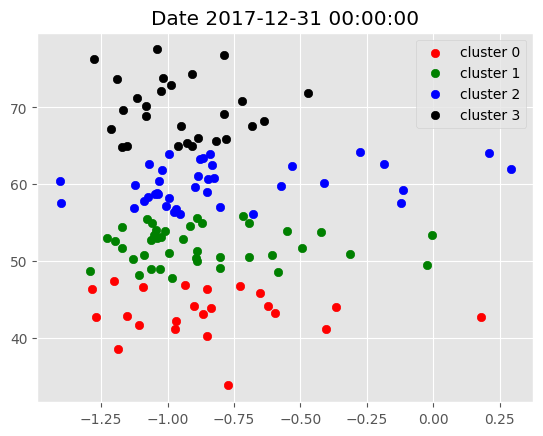

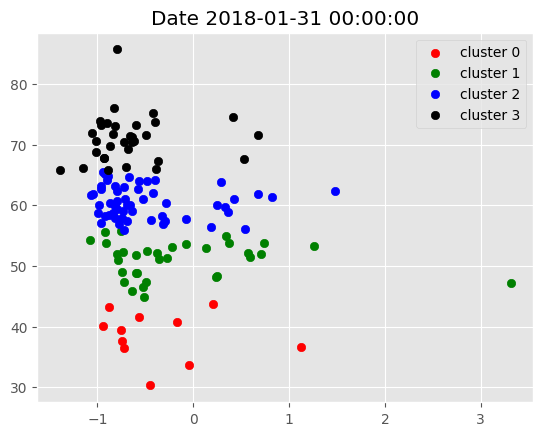

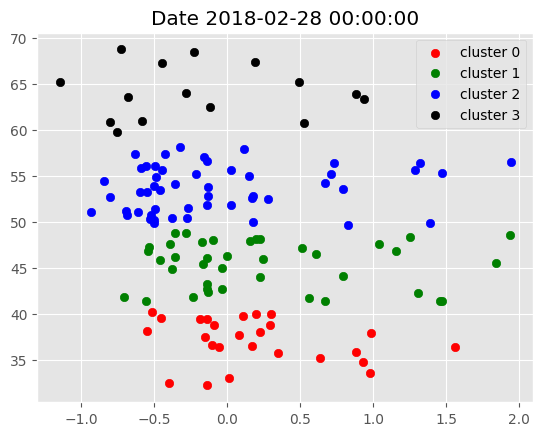

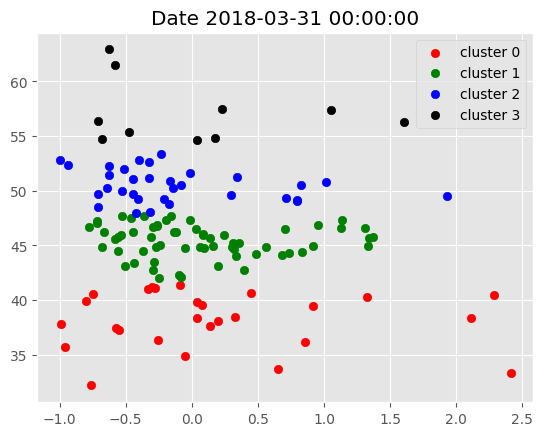

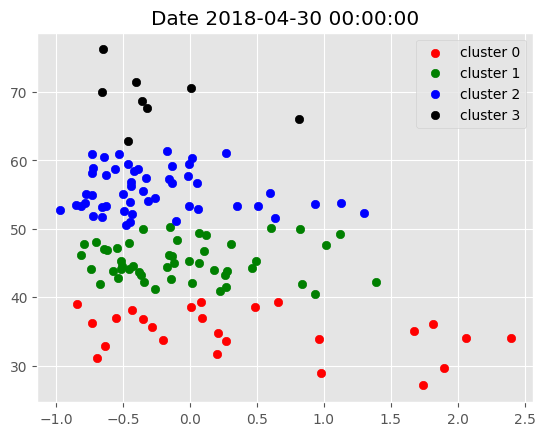

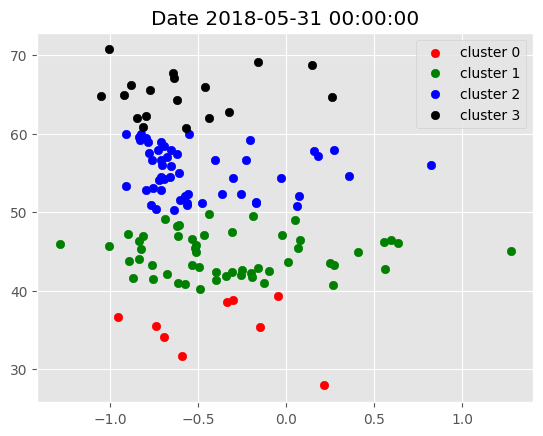

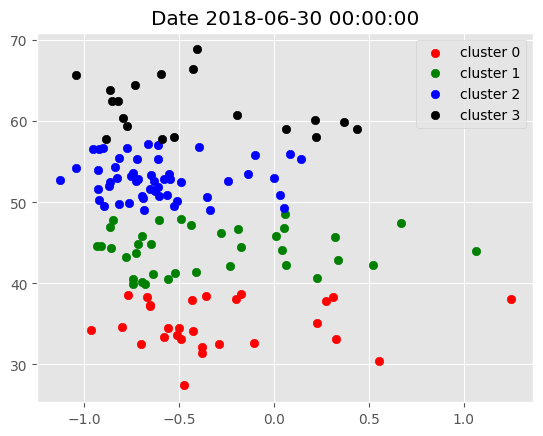

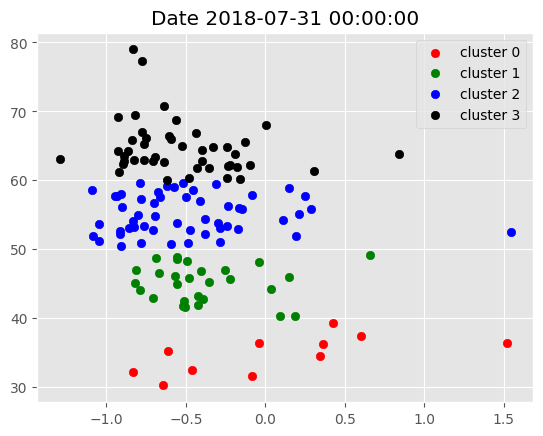

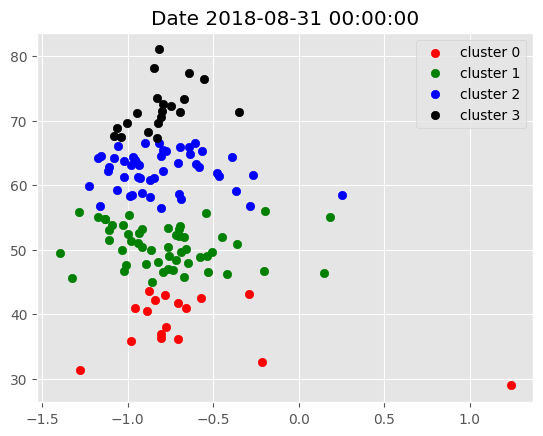

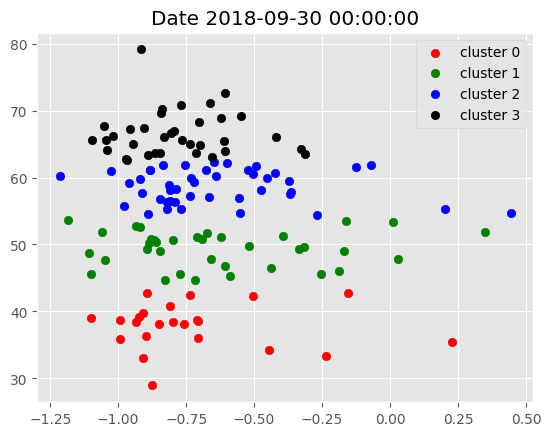

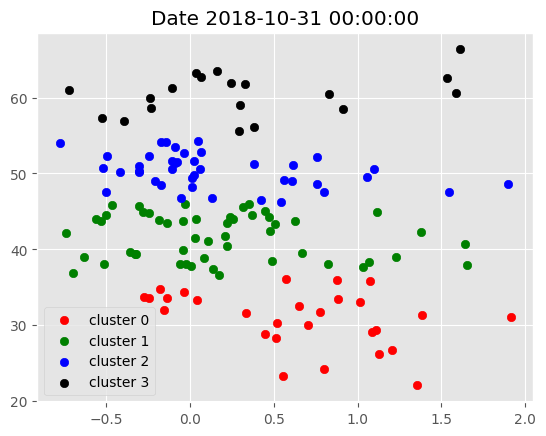

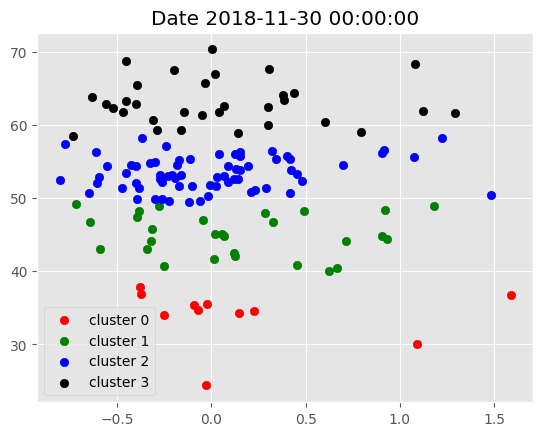

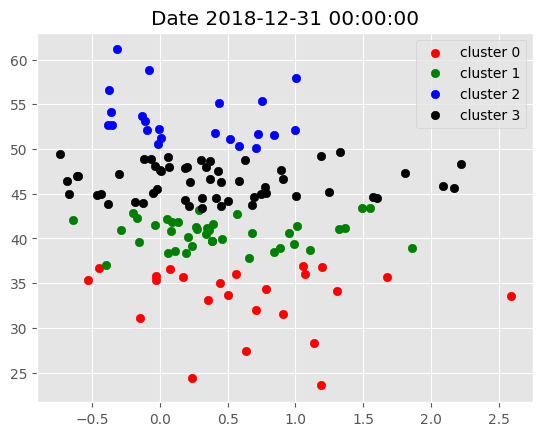

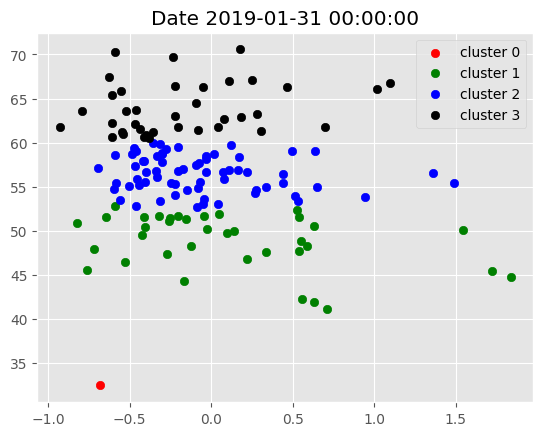

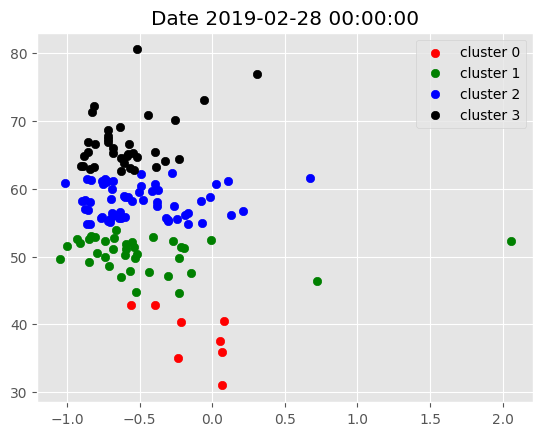

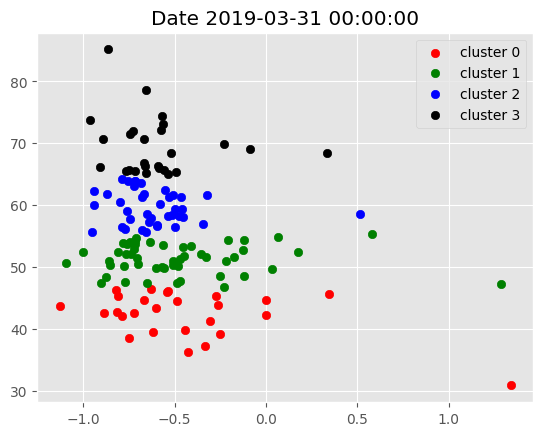

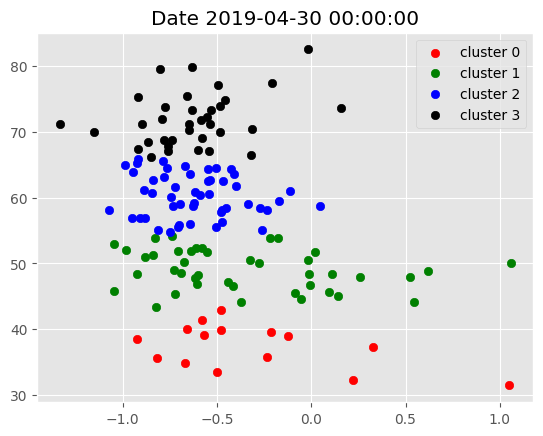

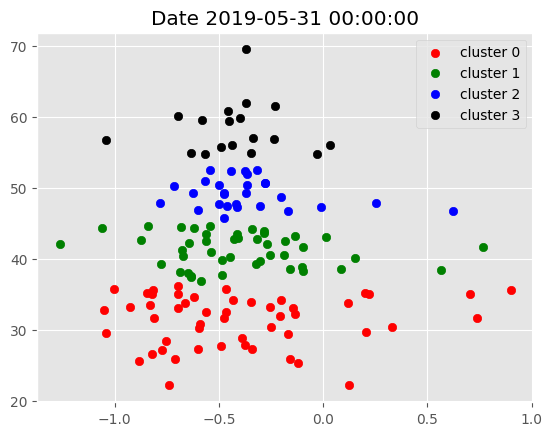

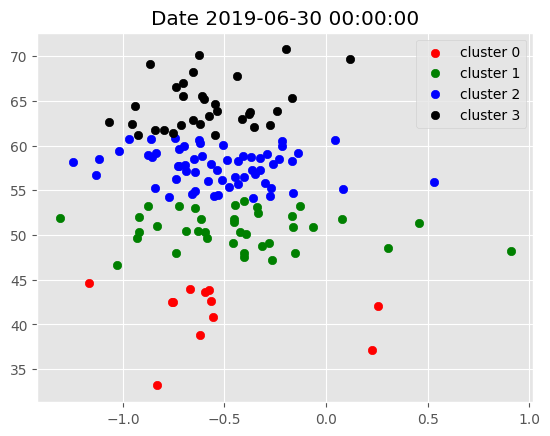

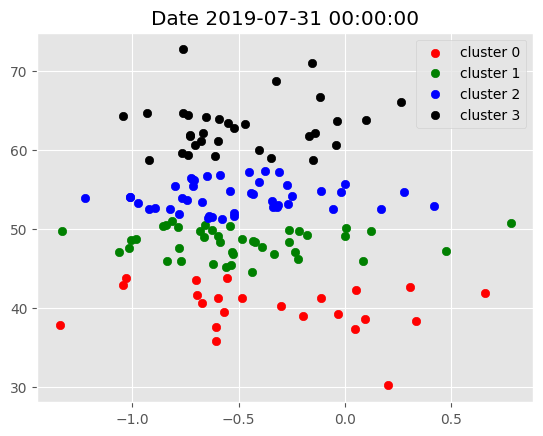

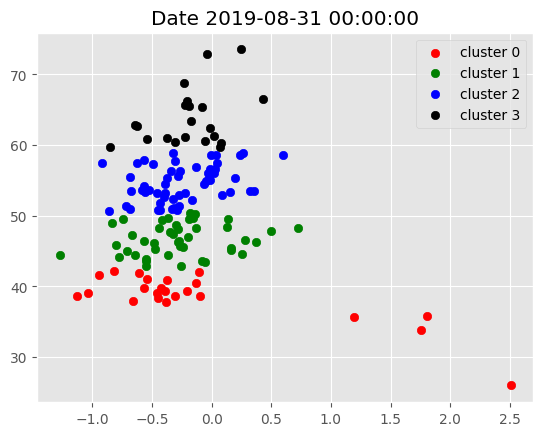

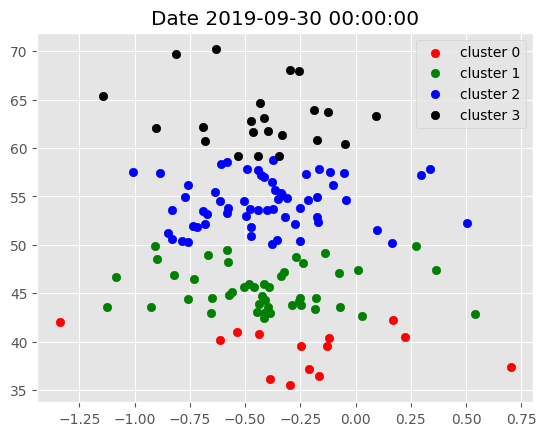

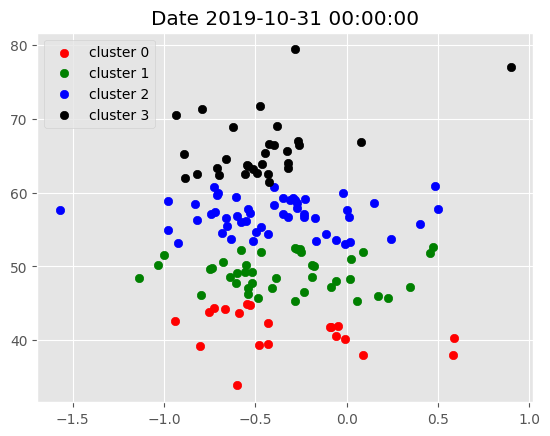

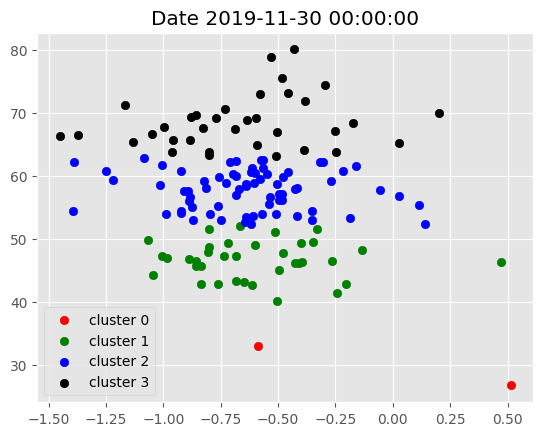

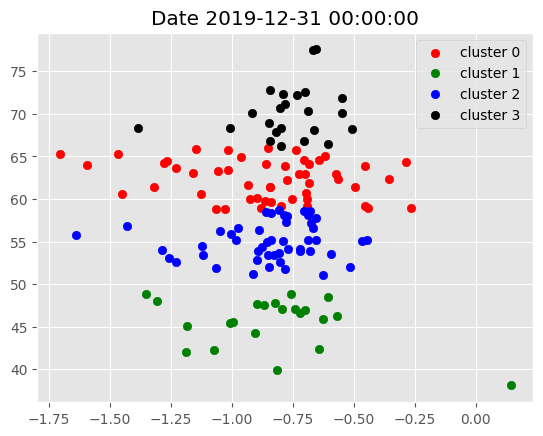

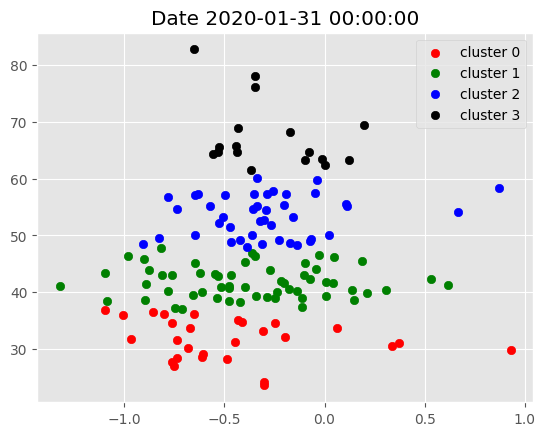

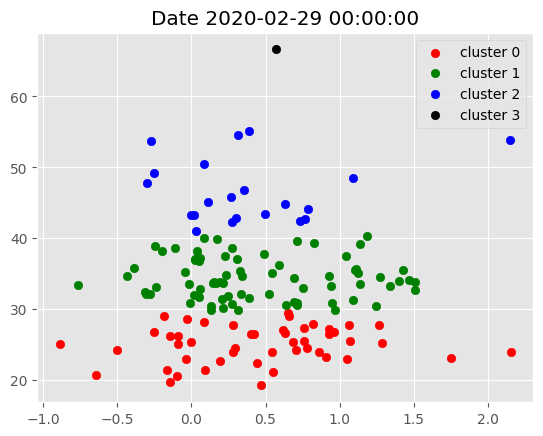

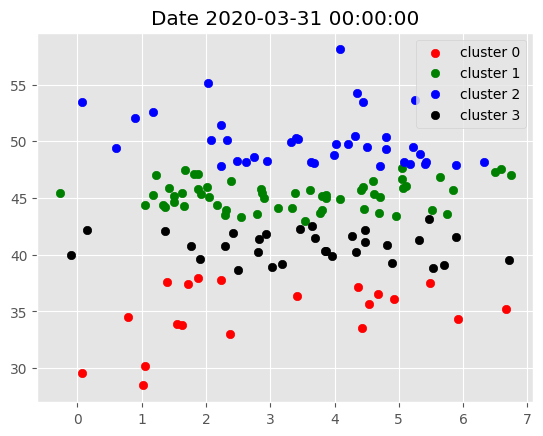

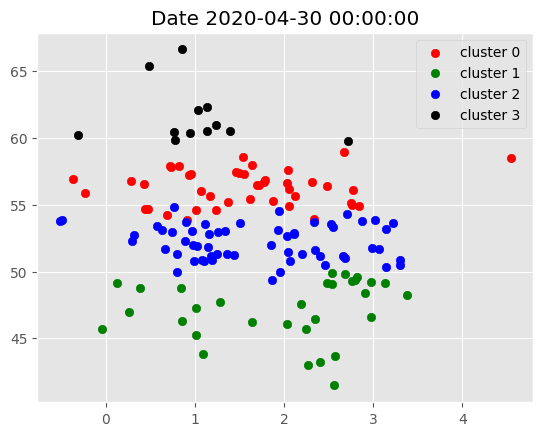

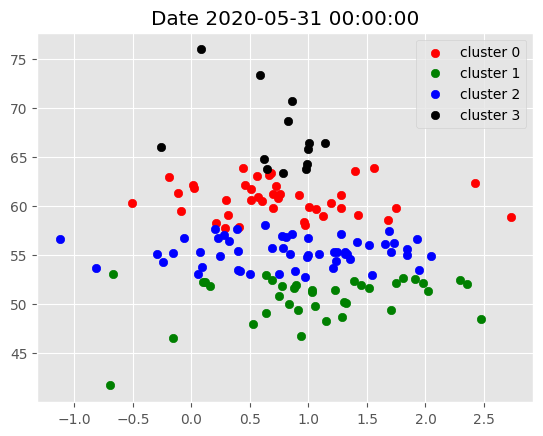

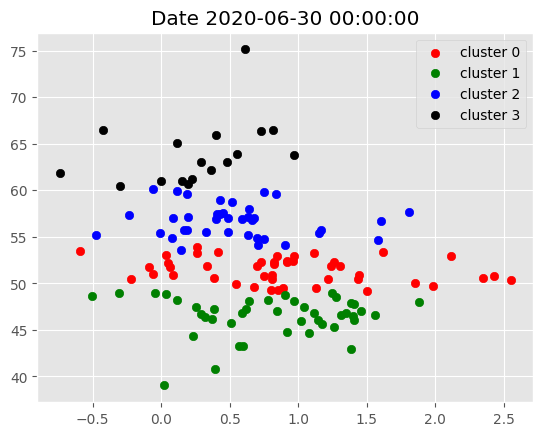

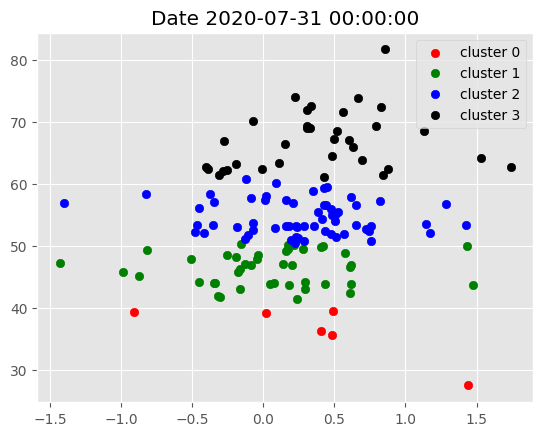

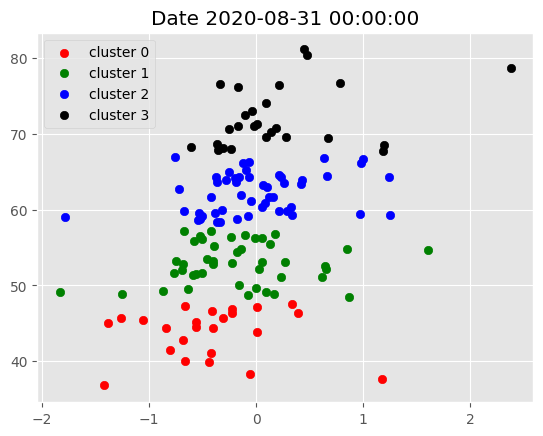

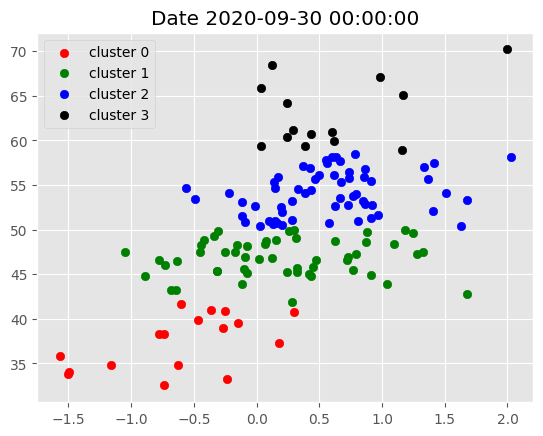

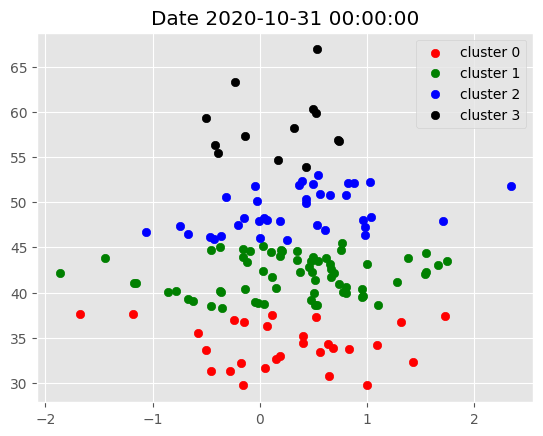

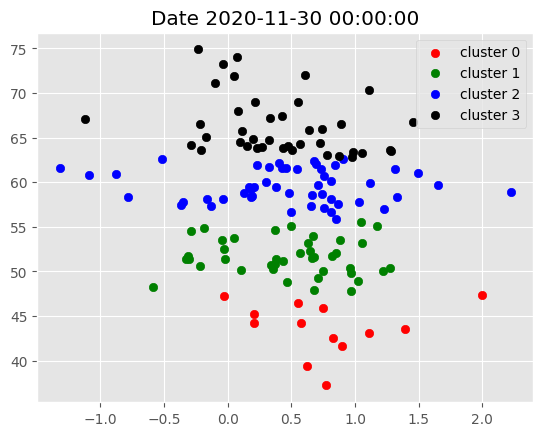

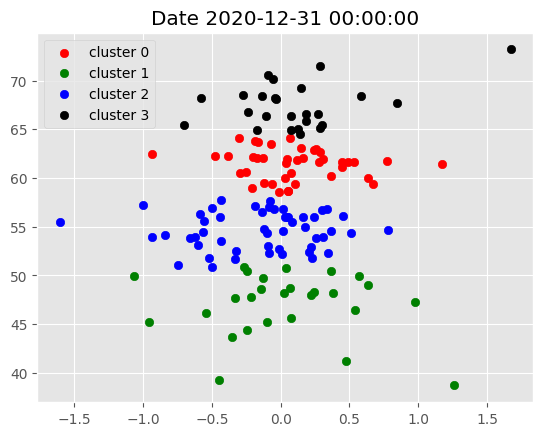

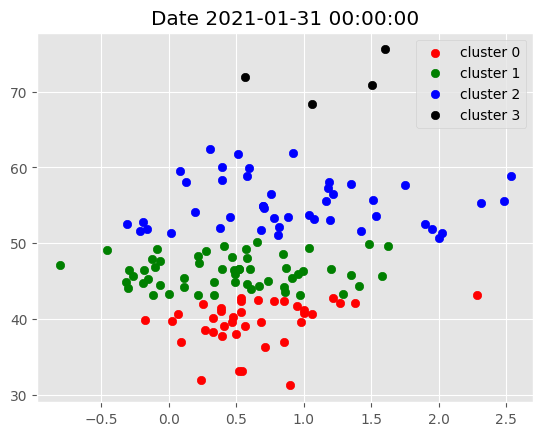

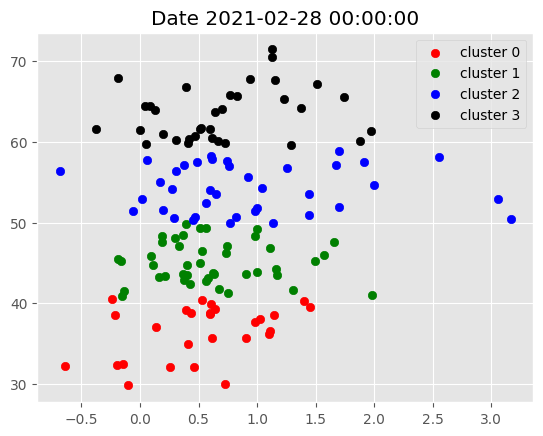

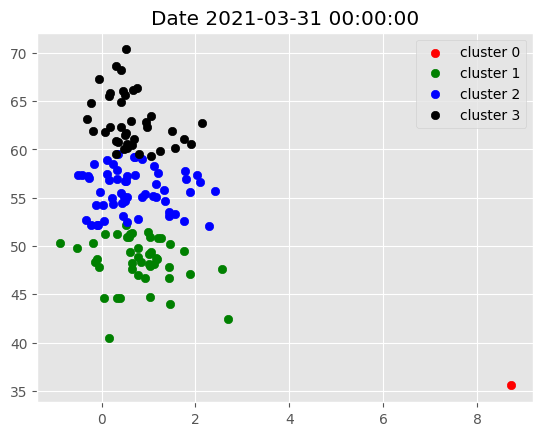

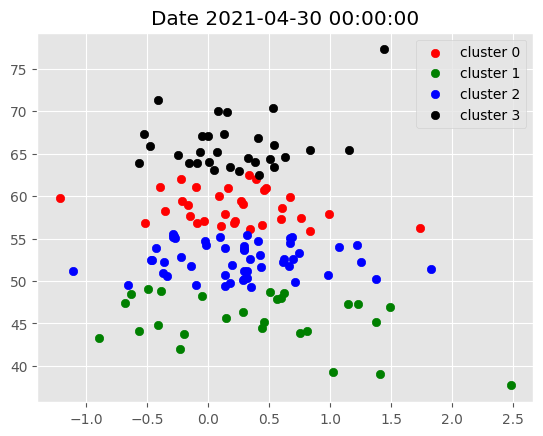

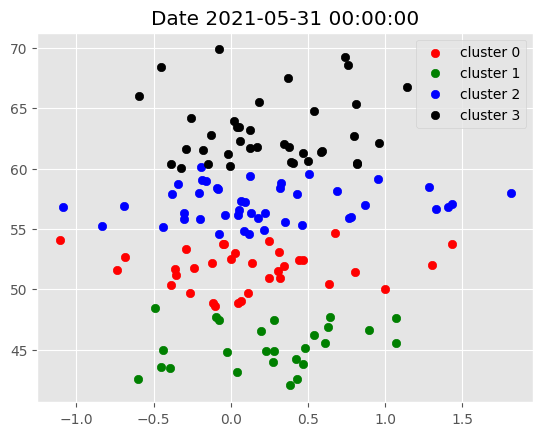

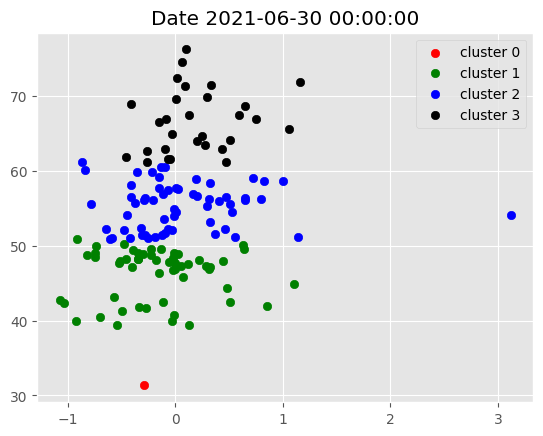

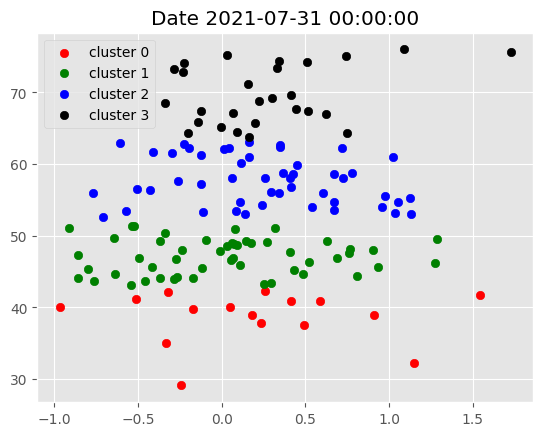

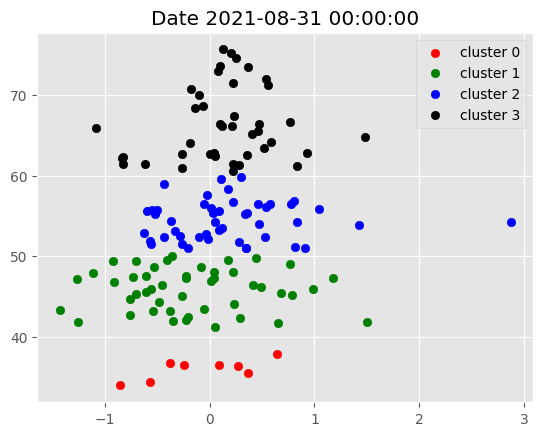

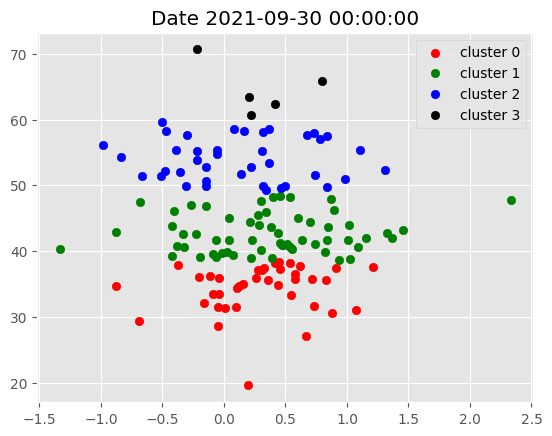

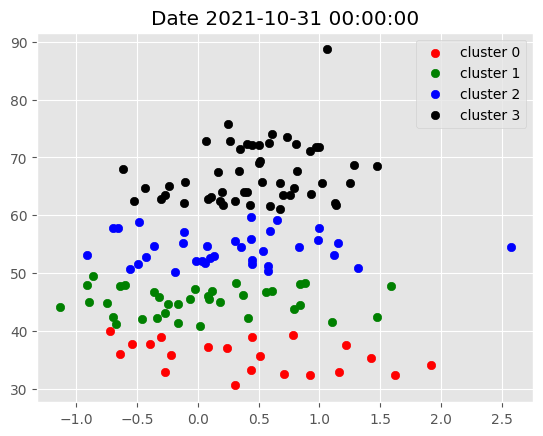

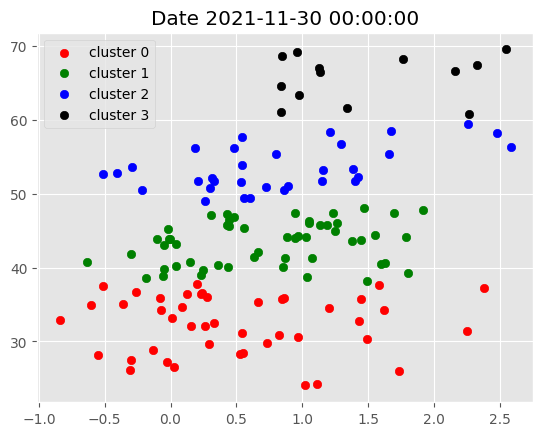

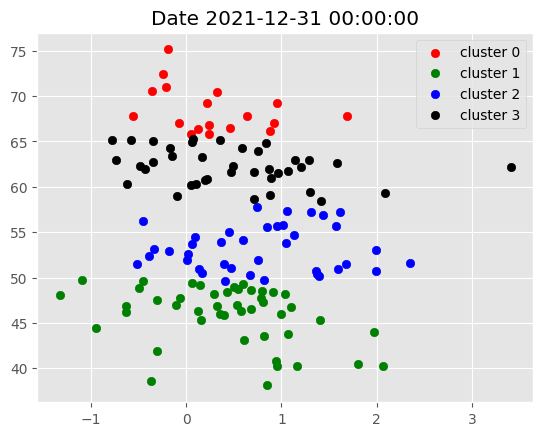

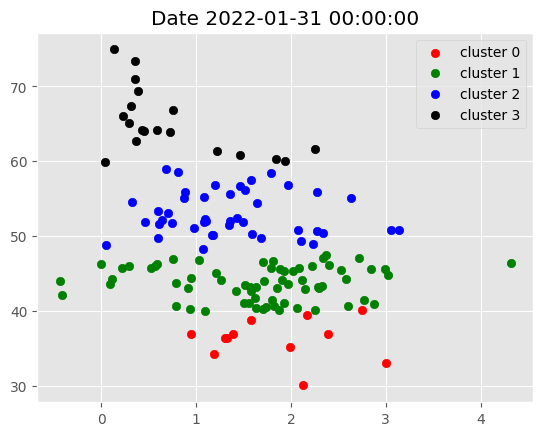

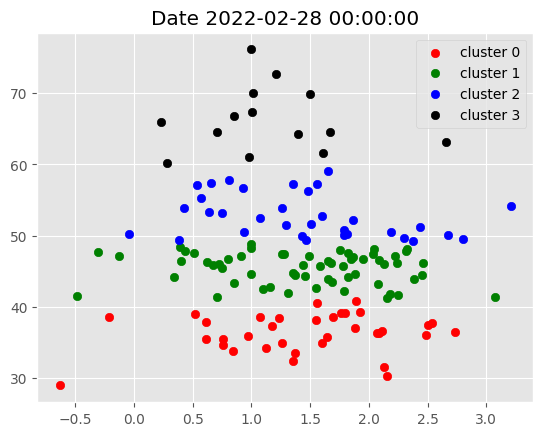

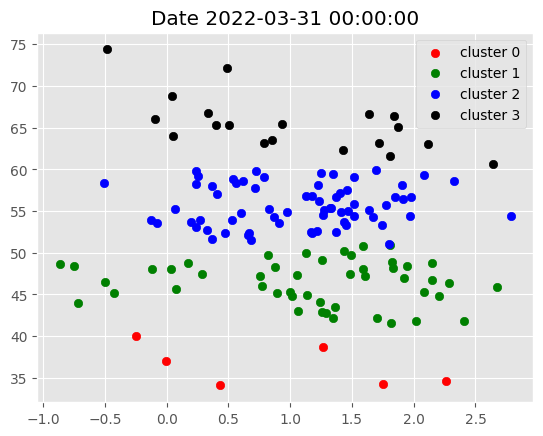

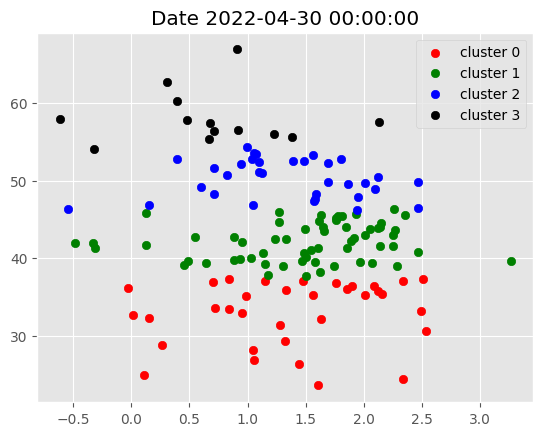

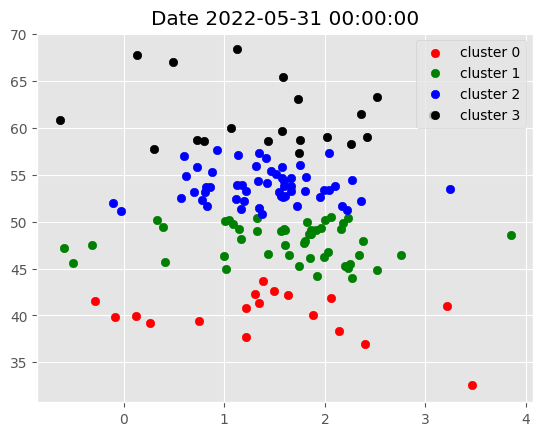

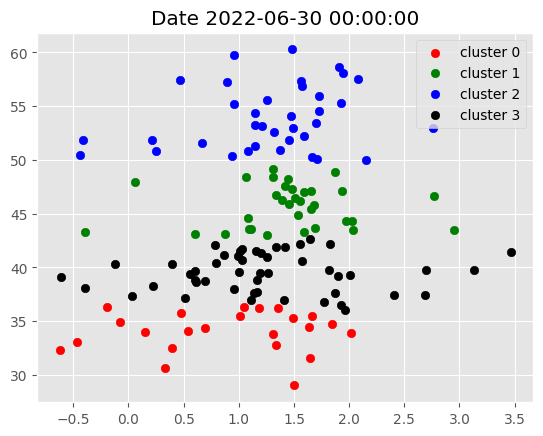

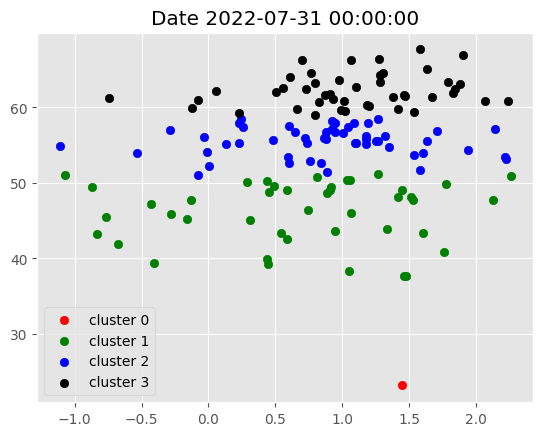

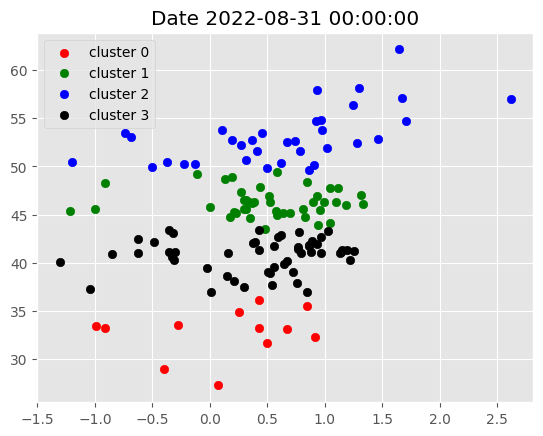

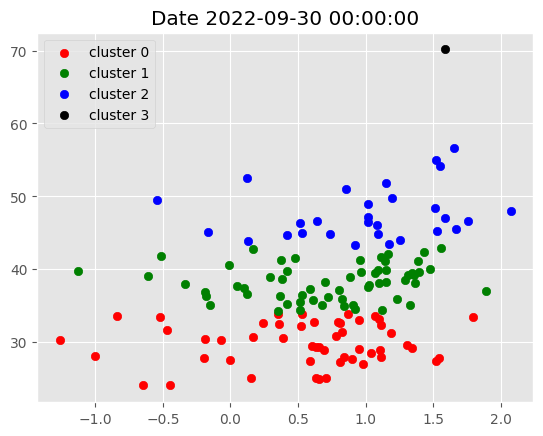

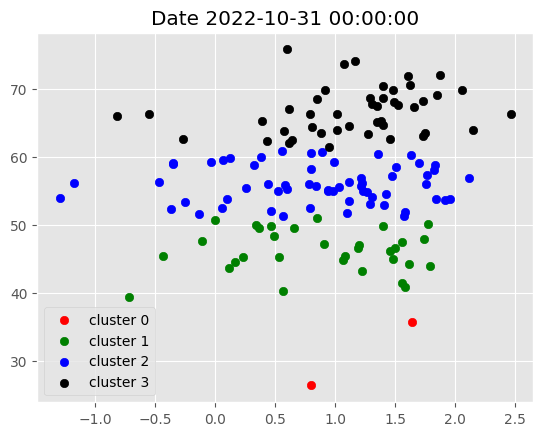

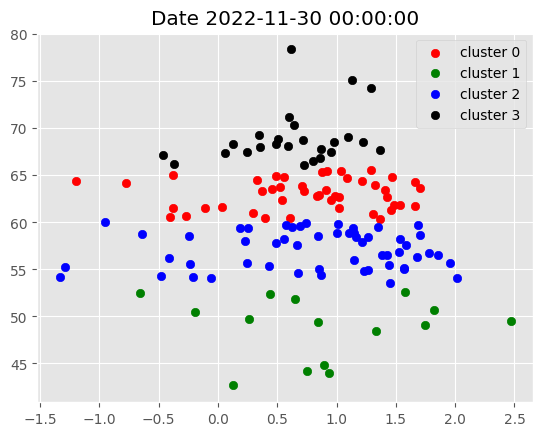

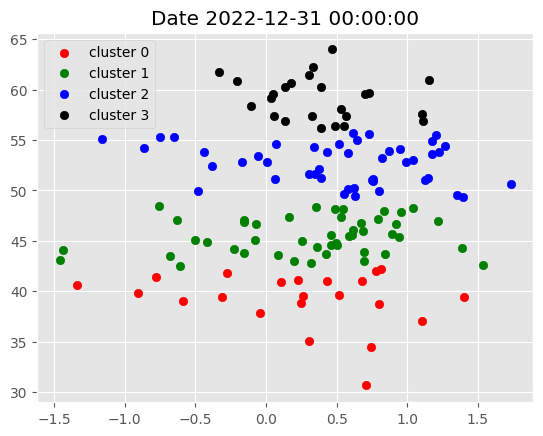

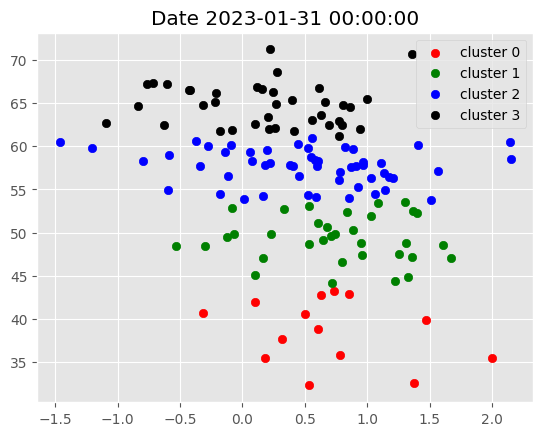

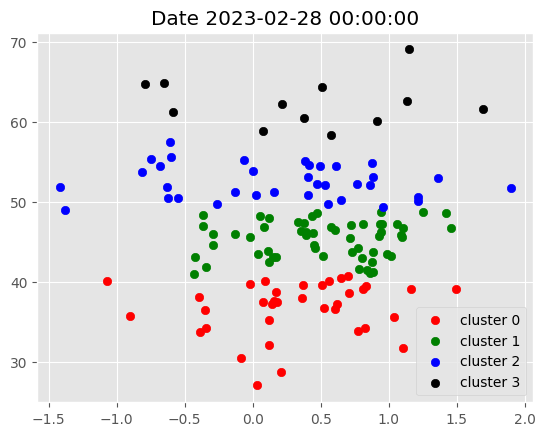

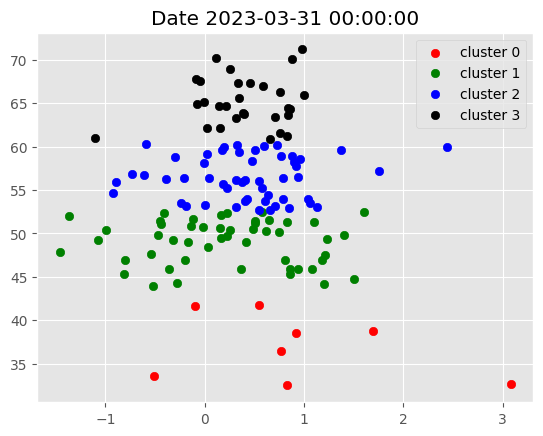

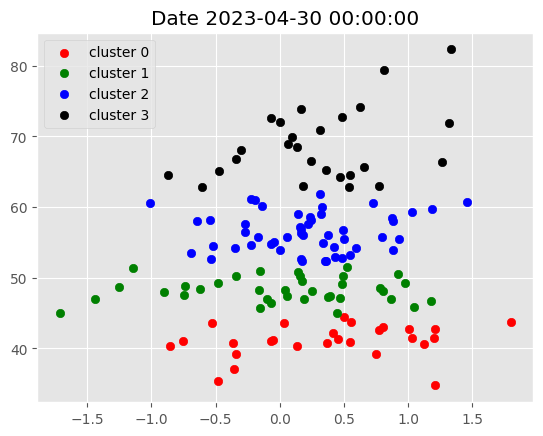

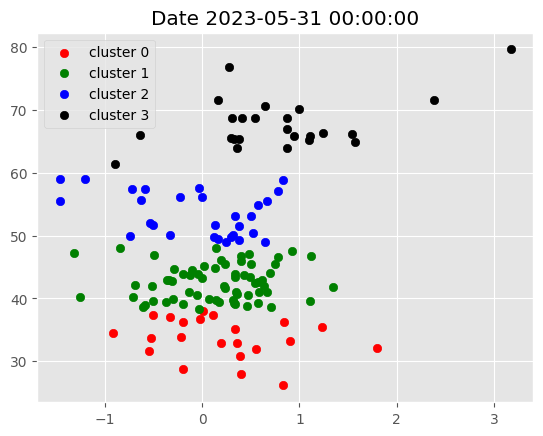

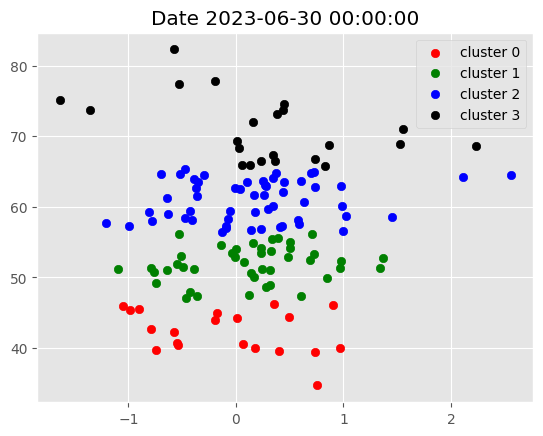

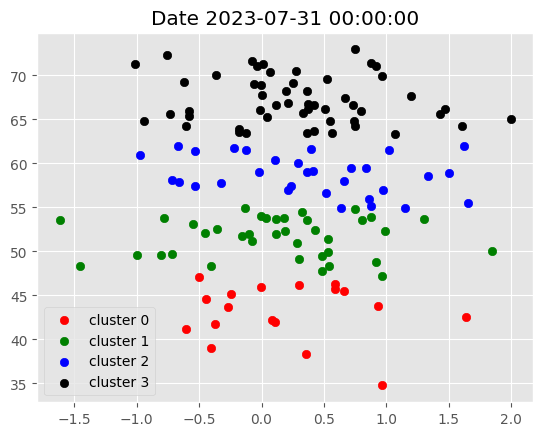

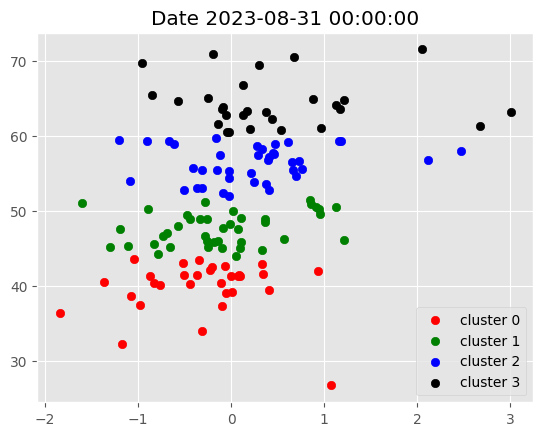

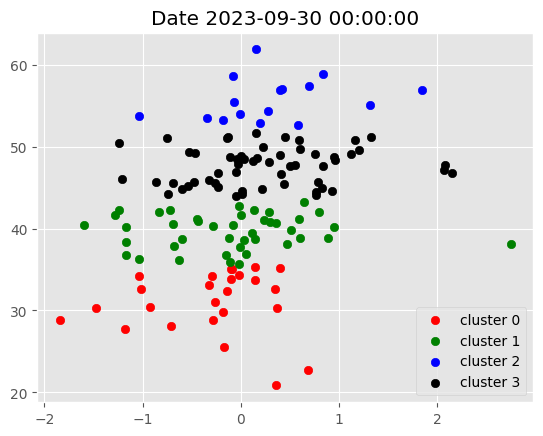

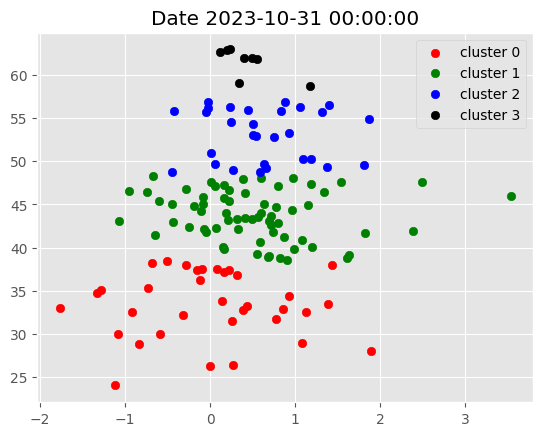

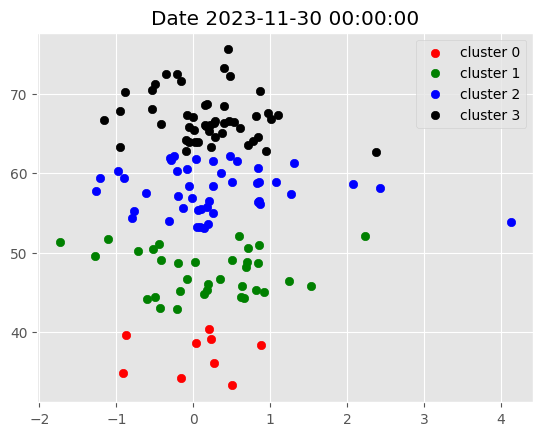

In [26]:
# Visualise clusters for every month
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level =0)
    plt.title(f'Date {i}')
    plot_clusters(g)

### Portfolio Selection Based on Cluster and Efficient Frontier

This section of the code focuses on selecting assets from a specific cluster (cluster 3 in this case) for portfolio construction. It first filters the dataset to include only the assets belonging to the chosen cluster and then adjusts the index to account for the time shift typically involved in trading based on past data. The assets are then grouped by date, creating a dictionary (`fixed_dates`) that maps each date to the list of tickers identified for potential inclusion in the portfolio. This structured approach sets the stage for subsequent portfolio optimization steps, where the selected assets will be analyzed and combined based on the Efficient Frontier method, specifically targeting the maximum Sharpe ratio to balance return and risk effectively. This methodical selection and organization of assets are crucial for constructing a robust, performance-optimized portfolio.

In [30]:
# Select assets based on cluster and form portfolio based on Efficient Frontier max sharpe ratio optimisation
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates ={}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

fixed_dates


{'2018-01-01': ['ACN',
  'BA',
  'CAT',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',

### Defining Portfolio Optimization Function

This section introduces a function to optimize a portfolio's asset weights using the Efficient Frontier method, aiming for the maximum Sharpe ratio—a measure of risk-adjusted return. It utilizes the `PyPortfolioOpt` library, which provides tools for expected returns and risk models. The function calculates the mean historical return and the sample covariance matrix of asset prices, then applies these to the Efficient Frontier model with constraints on individual asset weights. The optimization seeks the asset weight distribution that maximizes the Sharpe ratio, balancing return and risk. Additionally, the function prepares for optimization by downloading historical price data for the shortlisted stocks from the selected cluster. This comprehensive approach ensures that the portfolio is constructed from a risk and return perspective, aiming to achieve the best possible performance under the given constraints.

In [31]:
# Define Portfolio Optimization Function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [32]:
# Download Daily Prices Data only for short listed stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = pdr.get_data_yahoo(stocks, 
                            start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                            end = data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-03  44.741230   27.023701   45.883400   34.462345  104.547821   
2017-01-04  45.127758   26.993462   46.530380   34.735924  104.799156   
2017-01-05  44.345032   27.130726   46.883274   35.035988  103.228172   
2017-01-06  44.654259   27.433193   46.897980   35.989098  104.404182   
2017-01-09  45.494968   27.684467   47.206757   35.953800  103.237152   
...               ...         ...         ...         ...         ...   
2023-11-22  12.310000  191.309998  138.470001  102.699997  333.130005   
2023-11-24  12.310000  189.970001  138.669998  102.870003  334.040009   
2023-11-27  12.180000  189.789993  139.089996  102.709999  332.429993   
2023-11-28  12.170000  190.399994  138.080002  102.059998  332.559998   
2023-11-29  12.230000  189.369995  138.500000  103.629997  333.339996   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-03  103.480003   89.319794   76.180000  54.072823   29.419779  ...   
2017-01-04  104.139999   89.457870   77.519997  54.778618   29.696108  ...   
2017-01-05  105.910004   88.922798   76.930000  54.471386   29.567152  ...   
2017-01-06  108.300003   88.983223   79.300003  55.476124   29.511892  ...   
2017-01-09  108.570000   88.430916   79.589996  55.119064   30.193499  ...   
...                ...         ...         ...        ...         ...  ...   
2023-11-22  619.719971  229.757233  202.660004  64.620644  149.479996  ...   
2023-11-24  619.429993  229.270187  203.419998  64.859352  150.339996  ...   
2023-11-27  619.270020  227.779236  202.259995  64.899139  150.809998  ...   
2023-11-28  623.320007  227.610260  207.369995  64.292419  148.059998  ...   
2023-11-29  617.390015  227.779236  213.850006  64.481400  149.360001  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-01-03  13785200  4425000  1761900  22891700   4942700  4479000  22063800   
2017-01-04   8033100  7431000  1667700  18316100   4125500  3653200  15036100   
2017-01-05   7805100  6450600  2354700  13840600   7401400  3638300  18831600   
2017-01-06   8898300  3771700  1669800  15615000   3949700  3274300  18715900   
2017-01-09   7305300  5132600  4522500  14097200   3293000  3909600  21794100   
...              ...      ...      ...       ...       ...      ...       ...   
2023-11-22   5701400  2631200   913500  14613100   7681100  3444100  11862200   
2023-11-24   1640900  1204900   658700   6766700   4317300  2262100   5287200   
2023-11-27   5478900  2455000  1308600  15245300  12146200  4263700  15715000   
2023-11-28   5234900  2045500  1154100  14521700  12559400  4208800  15332900   
2023-11-29   4955100  3180500  1497200  16387400  11255200  4765800  16746000   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-01-03  10473200  2703500  10360600  
2017-01-04   7918000  2598800   9434200  
2017-01-05   7099200  2507500  14443200  
2017-01-06   9491100  1858400  16518100  
2017-01-09   8685200  2776200  13762300  
...              ...      ...       ...  
2023-11-22   8805500  1400000  18072000  
2023-11-24   4658400  1008100   9480800  
2023-11-27   7797900  1889400  18013500  
2023-11-28   7845000  3616000  20629500  
2023-11-29   9965500  3810200  26802100  

[1739 rows x 930 columns]

### Dynamic Portfolio Optimization and Performance Calculation

This code segment is dedicated to dynamically optimizing a portfolio's asset allocation and calculating its performance over time. It iteratively goes through each month, selecting stocks based on the predefined cluster and date criteria, and then applies the previously defined optimization function to determine the best weights for the selected assets. Here's a breakdown of the process:

1. **Iterative Optimization:** For each month, the code identifies the stocks to include based on the cluster analysis and sets the time frame for optimization using historical data. It attempts to optimize the portfolio using the Efficient Frontier method to maximize the Sharpe ratio. If the optimization fails, it defaults to equal weighting among the selected stocks.

2. **Calculating Returns:** After determining the weights, it calculates the weighted returns for the portfolio over the month. This involves multiplying the daily returns of each stock by its optimized weight and summing these to get the portfolio's overall daily return.

3. **Handling Exceptions:** The code is robustly designed to handle any errors or exceptions that might occur during the optimization or return calculation process, ensuring that the analysis can continue uninterrupted.

4. **Compiling Results:** The weighted returns are compiled into a dataframe, providing a time series of the portfolio's performance. This allows for an evaluation of how the optimized portfolio would have performed historically, offering insights into the effectiveness of the strategy.

The resulting `portfolio_df` is a comprehensive record of the strategy's returns over time, providing a basis for further analysis, comparison with benchmarks, or refinement of the trading strategy. This dynamic and data-driven approach to portfolio management leverages both machine learning clustering and financial optimization techniques to aim for superior performance.

In [33]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-01-02,-0.000663
2018-01-03,0.004852
2018-01-04,0.001484
2018-01-05,0.005238
2018-01-08,0.002648
...,...
2023-11-22,0.009437
2023-11-24,0.002481
2023-11-27,-0.005560


### Visualizing Portfolio Returns Against S&P 500 Benchmark

This code segment visualizes the cumulative returns of the dynamically optimized portfolio against the S&P 500 (SPY) as a benchmark, providing a comparative analysis of the strategy's performance. Here's how it works:

1. **Fetching Benchmark Data:** It retrieves historical adjusted close prices for the SPY ETF, a common proxy for the S&P 500, and calculates its daily returns.

2. **Merging Returns:** The daily returns of the SPY are merged with the strategy's returns to facilitate a direct comparison. Both sets of returns are in the same dataframe, `portfolio_df`.

3. **Calculating Cumulative Returns:** Cumulative returns for both the strategy and the SPY are calculated. This involves compounding the daily returns over time to reflect the total return trajectory.

4. **Visualization:** The cumulative returns are plotted using a line graph, with the strategy's performance and the SPY's performance clearly delineated. The graph is styled for clarity and aesthetics, and the y-axis is formatted to display percentages.

5. **Analysis:** The resulting visualization provides a clear, intuitive comparison of the strategy's performance relative to a well-known market benchmark. This allows for an assessment of the strategy's effectiveness, risk, and potential for improvement.

By comparing the strategy's returns to the SPY, investors and analysts can gauge the added value or risk of the unsupervised learning-based trading strategy, making informed decisions about its application or further development. The visualization serves as a crucial tool for communicating performance and making strategic adjustments.

In [34]:
# Visualise Portfolio Returns and compare to SP500 returns

spy = pdr.get_data_yahoo(tickers='SPY', start = '2015-01-01', end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-01-02,-0.000663,0.007132
2018-01-03,0.004852,0.006305
2018-01-04,0.001484,0.004206
2018-01-05,0.005238,0.006642
2018-01-08,0.002648,0.001827
...,...,...
2023-11-22,0.009437,0.003853
2023-11-24,0.002481,0.000615
2023-11-27,-0.005560,-0.001803
2023-11-28,0.002558,0.000990


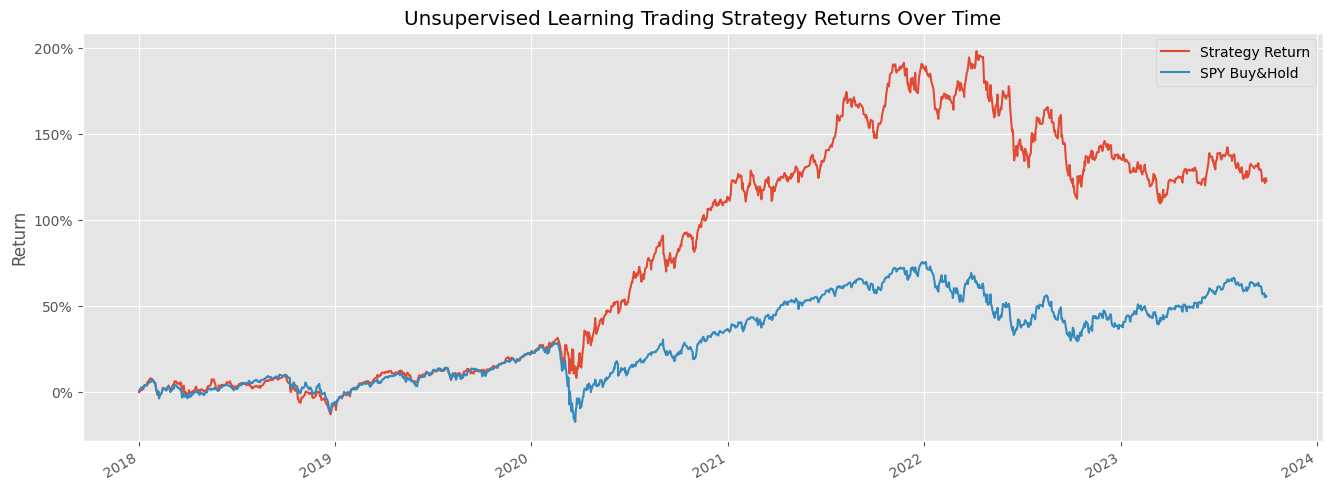

In [35]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

The chart above compares the returns of an unsupervised learning trading strategy against a buy-and-hold strategy in the SPY ETF from 2018 to the beginning of 2024. Initially, both strategies show similar returns, but from early 2019, the trading strategy significantly outperforms the SPY, peaking at nearly 200% return before experiencing higher volatility and a slight decline towards the end of the period. The buy-and-hold strategy exhibits a steadier but more modest growth. As of 2024, the trading strategy maintains a higher cumulative return despite its increased volatility compared to the benchmark.The chart compares the returns of an unsupervised learning trading strategy against a buy-and-hold strategy in the SPY ETF from 2018 to the beginning of 2024. Initially, both strategies show similar returns, but from early 2019, the trading strategy significantly outperforms the SPY, peaking at nearly 200% return before experiencing higher volatility and a slight decline towards the end of the period. The buy-and-hold strategy exhibits a steadier but more modest growth. As of 2024, the trading strategy maintains a higher cumulative return despite its increased volatility compared to the benchmark.